This notebook uses the LineDetection class to retrieve the coordinates of streaks in images. The purpose of this notebook is to provide an experimentation space to use that class structure and apply it on various images. 

You must have the line_detection.py file in the same folder as this notebook. Additionally, you should have a "Data" folder containing the images that you want to analyze. So far, this code has been tested on 8 images obtained from the following source:

https://epyc.astro.washington.edu/~dinob/dssg/



In [175]:
#Import the module and other libraries
import line_detection as ld
#import image_rotation
from astropy.io import fits
import astropy.visualization as aviz

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
#Set user filepath
'''
Since multiple people are using this file and we may have different filepaths, please set the filepath here. Filepath is basically a string that denotes which folder you want to navigate to. 
So if your datasets are in a folder called Images inside a folder called Home, then you can write current_user_filepath = 'Home/Images'

Please comment out the other users' filepaths, do not delete it. 

For example  --> img1 = fits.open(current_user_filepath + '/calexp-0941420_07.fits', cache = True)

'''
current_user_filepath = 'Data'





In [177]:
#Import your data
'''
I am pasting 8 images that I worked with to write this code. 
But you can use this format to import any image you want
'''

img1 = fits.open(current_user_filepath + '/calexp-0941420_07.fits', cache = True)
img2 = fits.open(current_user_filepath +'/calexp-0941422_33.fits', cache = True)
img3 = fits.open(current_user_filepath +'/calexp-0941424_34.fits', cache = True)
img4 = fits.open(current_user_filepath +'/calexp-0941426_16.fits', cache = True)
img5 = fits.open(current_user_filepath +'/calexp-0941424_37.fits', cache = True)
img6 = fits.open(current_user_filepath +'/STARLINK-1892-20220305200929.fits',cache = True)
img7 = fits.open(current_user_filepath +'/STARLINK-1892-N-20220305200959.fits',cache = True)
img8 = fits.open(current_user_filepath +'/STARLINK-1905-20220305191929.fits',cache = True)
img_multiple_streaks = fits.open(current_user_filepath + '/bi327715.fits', cache=True )


In [178]:
#Set up your image data
'''
Note:
Please check where the data actually lies in the fits file. You can do that my typing img1.info()
Usually, the image is in the first element i.e. img1[0], but in many cases it can be in the 
2nd element i.e. img1[1]. So before applying the line detection class, make sure your img_data
actually has data

These 2 lines are the code you should change when you want to work with a different image.
'''
#img_data = img3[1].data
img_data = img_multiple_streaks[0].data
img_data_copy = img_data.copy()



In [179]:
#Importing the class
detector = ld.LineDetection()




#Assigning initial parameters

The class needs certain parameters. You can check the code for the documentation of those parameters. 
But here are those:

        image = the image you want to detect streaks in
        
        mask = Takes True/False. If you want to mask the edges of the image or not
        mask_percent = percentage of edge you want to mask
        
        nstd1_normalize = Reduce outlier pixel intensities beyond these many standard
        deviations in the first cut of processing the image
        nstd2_normalize = Same as above, but for the second cut of image processing
        
        
        threshold = the percentage of diagonal length you want to successfully vote 
                    a line of pixels as a straight line streak
        




Threshold: 289 pixels
Found 90 lines.
original image
<class 'numpy.ndarray'>
(2048, 2048)
Thresholded image
<class 'numpy.ndarray'>
(2048, 2048)
blurred image
<class 'numpy.ndarray'>
(2048, 2048)
edge detected image
<class 'numpy.ndarray'>
(2048, 2048)
Contours MAR image
<class 'numpy.ndarray'>
(2048, 2048)
Detected line
<class 'numpy.ndarray'>
(2048, 2048)


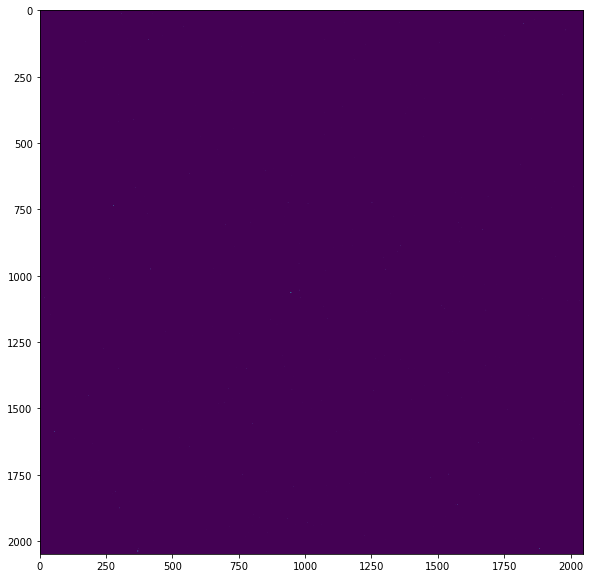

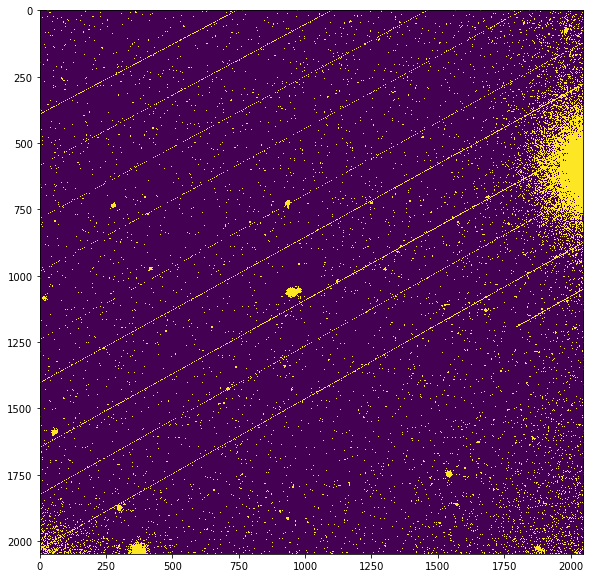

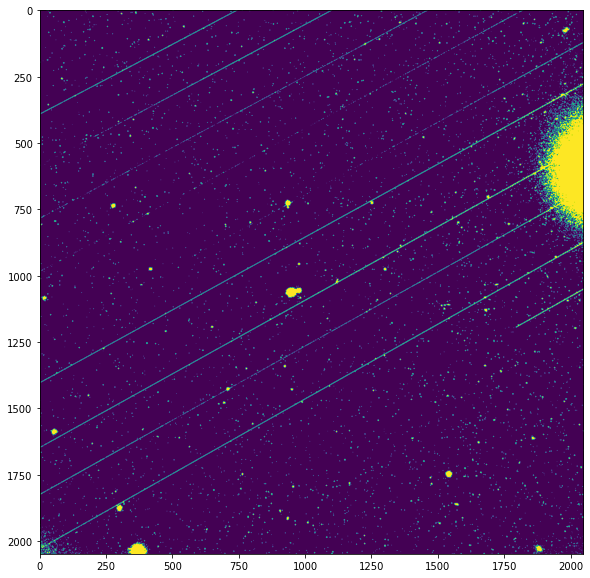

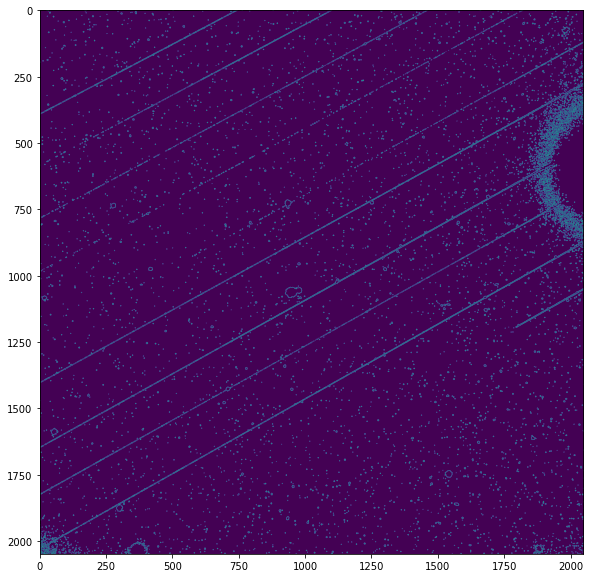

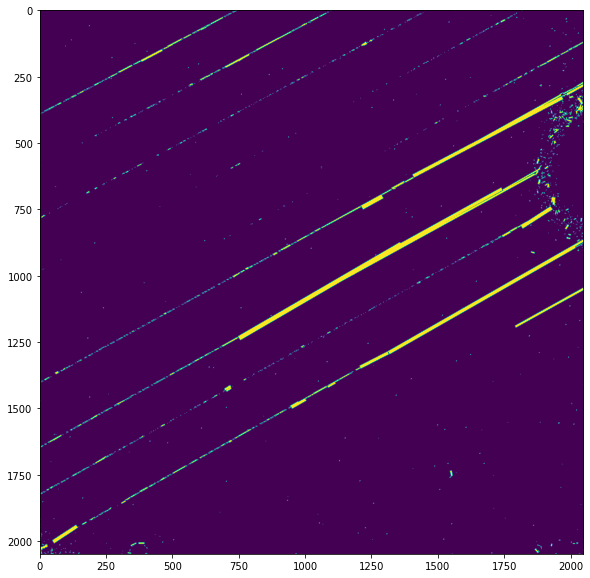

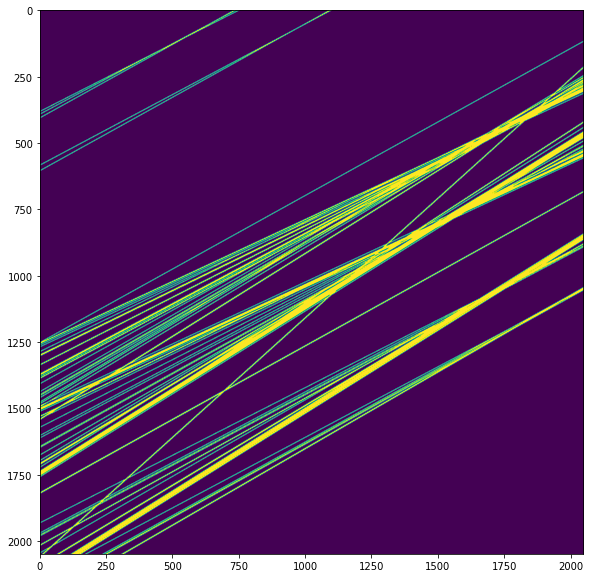

In [180]:
detector.image = img_data_copy
detector.mask = False
detector.erode = False
detector.erode_threshold = 5
detector.mask_percent = 0.2
detector.nstd1_cut = 2
detector.nstd2_binary_cut = 0.5
detector.threshold = 0.1

#Conduct the line detection
lined_img, thresholded_img, blurred_image, edges, contours_image, lines = detector.hough_transformation()

#Visualize
print("original image")
ld.show(img_data, interpolation='none')

print("Thresholded image")
ld.show(thresholded_img, interpolation='none')
plt.savefig('multiple_streaks_thresholded_img.png')

print("blurred image")
ld.show(blurred_image)

print("edge detected image")
ld.show(edges)
plt.savefig('multiple_streaks_canny_img.png')

print("Contours MAR image")
ld.show(contours_image)
plt.savefig('multiple_streaks_MAR_img.png')

print("Detected line")
ld.show(lined_img)
plt.savefig('multiple_streaks_detected_lines.png')



In [173]:
r = lines[:,0,0]
theta = lines[:,0,1]



/tmp/ipykernel_14864/203103384.py:1: RuntimeWarning: invalid value encountered in arccos
  plt.scatter(r, np.arctan(np.arccos(theta)), s=0.5)


Text(0.5, 0, 'r')

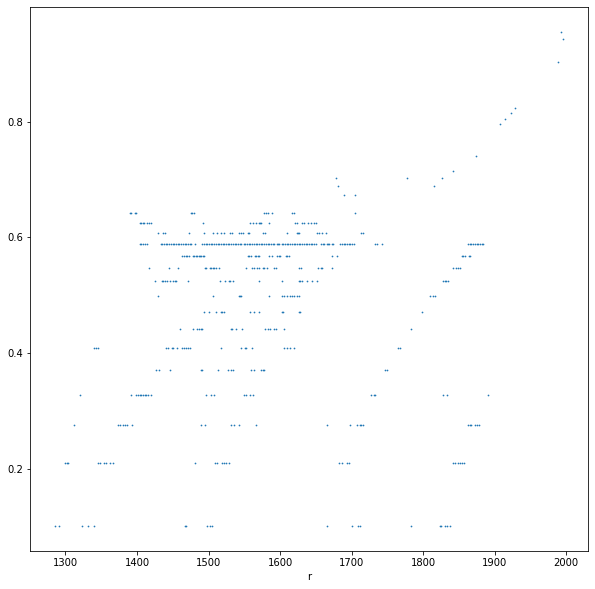

In [193]:
plt.scatter(r, np.arctan(np.arccos(theta)), s=0.5)
plt.xlabel("r")



In [127]:
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np




In [111]:
lines_array = lines[:,0,:]
r = lines_array[:,0].reshape(-1,1)
theta = lines_array[:,1].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(lines_array)  
std_lines = scaler.transform(lines_array)





bandwidth= 0.9066624717406242


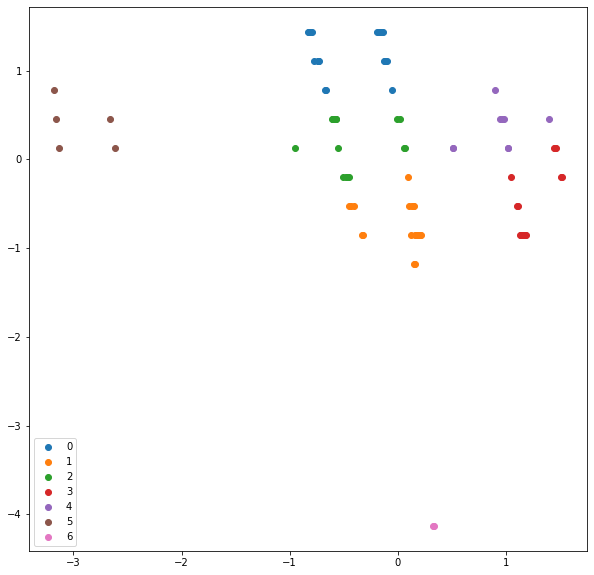

In [190]:

bandwidth = estimate_bandwidth(std_lines, quantile=0.2, n_samples=500)
print("bandwidth=", bandwidth)
clustering = MeanShift(bandwidth=0.7).fit(std_lines)


for l in set(clustering.labels_):
    mask = clustering.labels_ == l
    tmp_r = std_lines[:,0]
    tmp_theta = std_lines[:,1]
    
    plt.scatter(tmp_r[mask], tmp_theta[mask], label = l)


plt.legend()




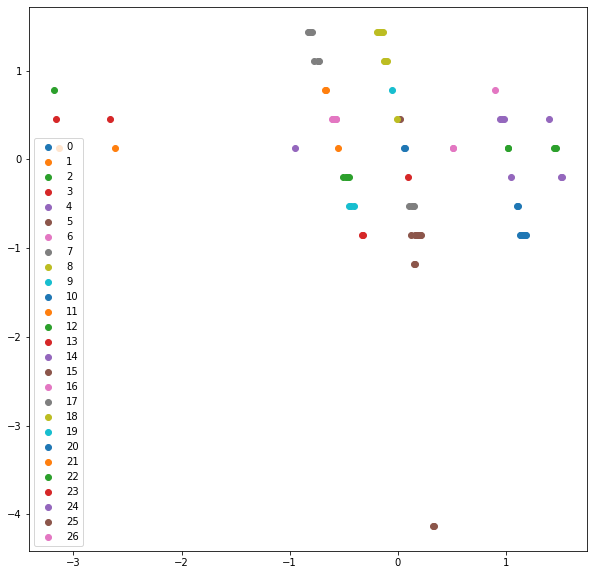

In [203]:
clustering = DBSCAN(eps=0.2, min_samples=1, metric='canberra').fit(std_lines)


for l in set(clustering.labels_):
    mask = clustering.labels_ == l
    tmp_r = std_lines[:,0]
    tmp_theta = std_lines[:,1]
    
    plt.scatter(tmp_r[mask], tmp_theta[mask], label = l)


plt.legend()



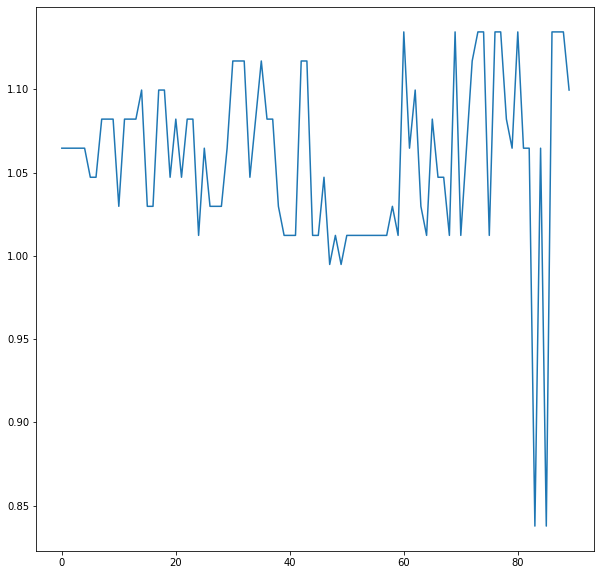

In [97]:
plt.plot(lines_array[:,1])

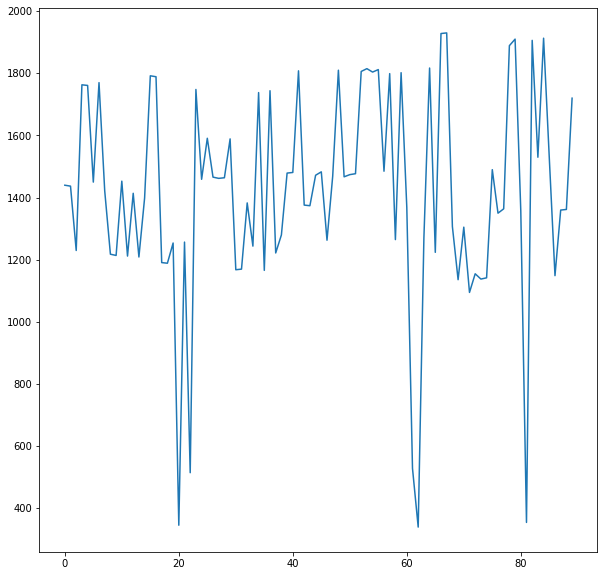

In [98]:
plt.plot(lines_array[:,0])

**IMAGE ROTATION SECTION**

In [ ]:
rot = image_rotation.ImageRotation()
rot.image = lined_img
rot.polar_coor = lines

In [ ]:
edge.shape

In [ ]:
rot.coord_all_lines(rot.polar_coor)

In [ ]:
rot.mean_coordinates(rot.coordinates)

In [ ]:
rot.rotate_image()

In [ ]:
detector.show(rot.rotated_image)